In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import nltk
nltk.download('punkt')
import pickle
import string
from transformers import AutoTokenizer
import transformers

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# rich: for a better display on terminal
from rich.table import Column, Table
from rich import box
from rich.console import Console

from transformers import T5Tokenizer, T5ForConditionalGeneration

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from jiwer import wer

In [ ]:
!pip install sentencepiece==0.1.94

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load T5 small

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")

model = T5ForConditionalGeneration.from_pretrained("t5-small")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device).float #lower resolution of integers for better gpu performance

<bound method PreTrainedModel.float of T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bi

In [ ]:

from google.colab import drive
drive.mount('/content/drive/')
path='/content/drive/My Drive/Ydata/'

Mounted at /content/drive/


###Data discovery

In [ ]:
datadf=pd.read_csv("/content/drive/My Drive/Ydata/spell_correction_task.tsv",sep = '\t')

In [ ]:
datadf.head()

,text,corrected
0,It is the headquurgers of Ughelly South LGA.,It is the headquarters of Ughelli South LGA.
1,"Upon completion of studies, he xeturned to Nig...","Upon completion of studies, he returned to Nig..."
2,"Bernie M. Farber (bgorn 1951) is j writer, com...","Bernie M. Farber (born 1951) is a writer, comm..."
3,The teafm fielded the Nos. 77 and 97 in the NA...,The team fielded the Nos. 77 and 97 in the NAS...
4,"This is a list of hoads ol state, heads of gov...","This is a list of heads of state, heads of gov..."


In [ ]:
datadf.shape

(90000, 2)

<BarContainer object of 187 artists>

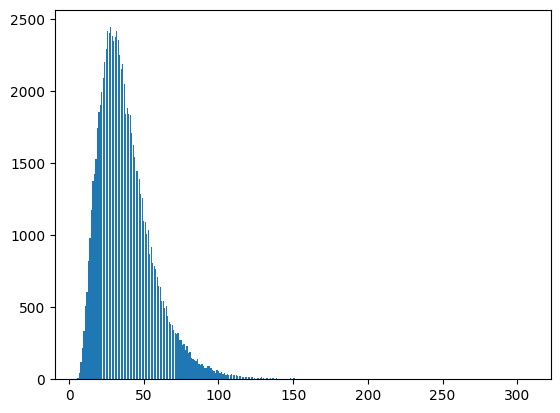

In [ ]:
lengths=[]
for i in datadf.text:
  l=len(tokenizer(i)['input_ids'])
  lengths.append(l)

lengths=np.array(lengths)
L, C = np.unique(lengths, return_counts=True)
plt.bar(L,C)

In [ ]:
max_len=200


In [ ]:
tokenizer(datadf.text[0]),datadf.text[0]

({'input_ids': [94, 19, 8, 819, 2436, 450, 1304, 7, 13, 412, 122, 88, 6073, 1013, 301, 6302, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 'It is the headquurgers of Ughelly South LGA.')

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer(datadf.text[0])['input_ids'])

['▁It',
 '▁is',
 '▁the',
 '▁head',
 'qu',
 'ur',
 'ger',
 's',
 '▁of',
 '▁U',
 'g',
 'he',
 'lly',
 '▁South',
 '▁L',
 'GA',
 '.',
 '</s>']

In [ ]:
tokenizer(datadf.corrected[0]),datadf.corrected[0]

({'input_ids': [94, 19, 8, 13767, 13, 412, 122, 107, 7999, 1013, 301, 6302, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 'It is the headquarters of Ughelli South LGA.')

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer(datadf.corrected[0])['input_ids'])

['▁It',
 '▁is',
 '▁the',
 '▁headquarters',
 '▁of',
 '▁U',
 'g',
 'h',
 'elli',
 '▁South',
 '▁L',
 'GA',
 '.',
 '</s>']

###Data preprocessing

In [ ]:
class DataSetClass(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, dataframe, tokenizer, source_len, target_len, source_text, target_text
    ):
        """
        Initializes a Dataset class

        Args:
            dataframe (pandas.DataFrame): Input dataframe
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = self.data[target_text]
        self.source_text = self.data[source_text]

    def __len__(self):
        """returns the length of dataframe"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        # source_text = " ".join(source_text.split())
        # target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }

In [ ]:
maxsamples=50000
####train test split:
np.random.seed(24)
rand=np.arange(maxsamples)
np.random.shuffle(rand)
trainidx=rand[0:int(maxsamples*.7)]
validx=rand[int(maxsamples*.7):int(maxsamples*.8)]
testidx=rand[int(maxsamples*.8):maxsamples]

trainds=DataSetClass(datadf.iloc[trainidx].reset_index(),tokenizer,300,300,'text','corrected')
valds=DataSetClass(datadf.iloc[validx].reset_index(),tokenizer,300,300,'text','corrected')
testds=DataSetClass(datadf.iloc[testidx].reset_index(),tokenizer,300,300,'text','corrected')

batch_size = 2
dataloaderdict = {'train': DataLoader(trainds, batch_size=batch_size, shuffle=True),#"num_workers": 0
          'val': DataLoader(valds, batch_size=batch_size, shuffle=False),
          'test': DataLoader(testds, batch_size=batch_size, shuffle=True)}

### Model Training

In [ ]:
# # All modules in the
# modules_to_freeze = [model.encoder.block[i].layer[0] for i in range(len(model.encoder.block))]
# # And the decoder modules, which has both a SelfAttention (layer[0])
# modules_to_freeze.extend([model.decoder.block[i].layer[0] for i in range(len(model.decoder.block))])
# # and CrossAttention (layer[1]) block
# modules_to_freeze.extend([model.decoder.block[i].layer[1] for i in range(len(model.decoder.block))])

# for module in modules_to_freeze:
#     for param in module.parameters():
#         param.requires_grad = False  # Actual freezing operation

In [ ]:
def train_model(epochs,optimizer):
  since = time.time()
  sm=nn.Softmax(dim=2)
  print('Start training...')
  train_loss= []
  WERlist=[]
  itercounter=0
  for e in range(epochs):
    model.train()
    # data=next(iter(testloader))
    predictions = []
    actuals = []
    trainloss=0

    accum_batch=16

    for batch_idx, data in enumerate(dataloaderdict['train']):
      y = data["target_ids"].to(device, dtype=torch.long)
      y_ids = y[:, :-1].contiguous()
      lm_labels = y[:, 1:].clone().detach()
      lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
      ids = data["source_ids"].to(device, dtype=torch.long)
      mask = data["source_mask"].to(device, dtype=torch.long)

      outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )

      loss = outputs[0] #t5 uses cross entropy
      trainloss+=loss.item()


      loss.backward()

      if ((batch_idx + 1)  %  accum_batch ==0 ) or (batch_idx + 1 == len(dataloaderdict['train']) ):
        optimizer.step()
        optimizer.zero_grad()

      if ((itercounter + 1)  %  20 ==0 ):
        print(f'Iteration {itercounter} train loss: {trainloss/20}')
        train_loss.append(trainloss/20)
        trainloss=0

      itercounter+=1



    with torch.no_grad():
      model.eval()
      WER = 0
      itercounter=0

      for data in dataloaderdict['val']:
        y = data['target_ids'].to(device, dtype = torch.long)
        ids = data['source_ids'].to(device, dtype = torch.long)

        outputs = model.generate(input_ids=ids,max_length=max_len)

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in outputs]
        target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

        WER +=(wer(preds,target)) #appends one WER score per batch.

        if ((itercounter + 1)  %  5 ==0 ):
          print(f'Iteration val word error rate: {WER/5}')
          WERlist.append(WER/5)
          WER=0

        itercounter+=1
    print(f'epoch {e} done ')

  time_elapsed = time.time() - since
  print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')

  plt.subplot(1,2,1)
  plt.plot(train_loss)
  plt.title('Train Loss')
  plt.subplot(1,2,2)
  plt.plot(WERlist)
  plt.title('WER')
  plt.show()

Start training...
Iteration 19 train loss: 2.1066619873046877
Iteration 39 train loss: 1.6775645852088927
Iteration 59 train loss: 1.411790704727173
Iteration 79 train loss: 1.1410397052764893
Iteration 99 train loss: 1.102087128162384
Iteration 119 train loss: 1.118972572684288
Iteration 139 train loss: 1.092773887515068
Iteration 159 train loss: 0.9948354095220566
Iteration 179 train loss: 0.9651727795600891
Iteration 199 train loss: 0.9412327229976654
Iteration 219 train loss: 1.0091590285301208
Iteration 239 train loss: 0.9795812338590622
Iteration 259 train loss: 0.8971328645944595
Iteration 279 train loss: 0.8114889040589333
Iteration 299 train loss: 0.8386332899332046
Iteration 319 train loss: 0.7858011394739151
Iteration 339 train loss: 0.8622680142521858
Iteration 359 train loss: 0.8312368035316468
Iteration 379 train loss: 0.7651556611061097
Iteration 399 train loss: 0.8433351963758469
Iteration 419 train loss: 0.6964448317885399
Iteration 439 train loss: 0.7792301148176193
I

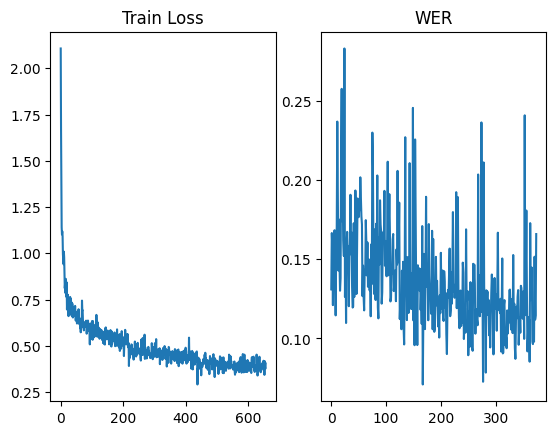

In [ ]:
batch_size = 8
dataloaderdict = {'train': DataLoader(trainds, batch_size=batch_size, shuffle=True,num_workers= 4),
          'val': DataLoader(valds, batch_size=batch_size, shuffle=False,num_workers= 4),
          'test': DataLoader(testds, batch_size=batch_size, shuffle=False,num_workers= 4)}

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
train_model(epochs=3,optimizer=optimizer)

pickle.dump(model, open("/content/drive/My Drive/Ydata/spell_correction_task.sav", 'wb'))

In [ ]:
model = pickle.load(open("/content/drive/My Drive/Ydata/spell_correction_task.sav", 'rb'))
model.to(device).float

<bound method PreTrainedModel.float of T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bi

### Explore results

In [ ]:
data=next(iter(dataloaderdict['test']))
y = data['target_ids'].to(device, dtype = torch.long)
ids = data['source_ids'].to(device, dtype = torch.long)

outputs = model.generate(input_ids=ids,max_length=max_len)

preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in outputs]
target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

In [ ]:
WERcorpus=wer(list(datadf.text),list(datadf.corrected))
WERcorpus
WERtest=wer(list(datadf.iloc[testidx].text),list(datadf.iloc[testidx].corrected))
WERtest
print(f'Corpus world error rate: {WERcorpus}, Test set word error rate: {WERtest}')

Corpus world error rate: 0.20838769986905925, Test set word error rate: 0.2083380883710797


In [ ]:

preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in outputs] #
target = [tokenizer.decode(t , skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y] #skip_special_tokens=True, clean_up_tokenization_spaces=True
preds

['The Display is an Australian ballet produced and chorographed by Robert Hetlmann to music by Malcoly Wipliamso for The Australian Ballet.',
 ', he was the announcer for The Late Late Show with Serge Ferguson on CBS, and as of July 2015, now serves as the primary continuity announcer for the Antenny TV network.']

In [ ]:
target

['The Display is an Australian ballet produced and choreographed by Robert Helpmann to music by Malcolm Williamson for The Australian Ballet.',
 'In television, he was the announcer for The Late Late Show with Craig Ferguson on CBS, and as of July 2015, now serves as the primary continuity announcer for the Antenna TV network.']

In [ ]:
original=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in data['source_ids'] ] #
original

['The Display is an Austrapian ballet pjoduced and chorcographed by Robert Hetlpmann to music ry Malcoly Wipliamso for The Auqtralian Ballet.',
 'In television, he was the announcer for The Late Late Show with Sraig Ferguson on CBS, asd as of July 2015, now ierves as the primary continuity announcer for the Antenny TV network.']

In [ ]:
wer(preds,target)

0.1509433962264151

In [ ]:
wer(original,target)

0.2222222222222222

In [ ]:
WER=[]
prevwer=[]
with torch.no_grad():
      model.eval()
      for data in dataloaderdict['test']:
        y = data['target_ids'].to(device, dtype = torch.long)
        ids = data['source_ids'].to(device, dtype = torch.long)

        outputs = model.generate(input_ids=ids,max_length=max_len)

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in outputs]
        target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
        original= [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in ids]

        WER.append(wer(preds,target))
        prevwer.append(wer(original,target))

In [ ]:
print(f'Average word error rate of model on test set: {np.array(WER).mean()}')

Average word error rate of model on test set: 0.11717935085033641


In [ ]:
print(f'Average word error rate in test data: {np.array(prevwer).mean()}')

Average word error rate in test data: 0.20744582535549544
